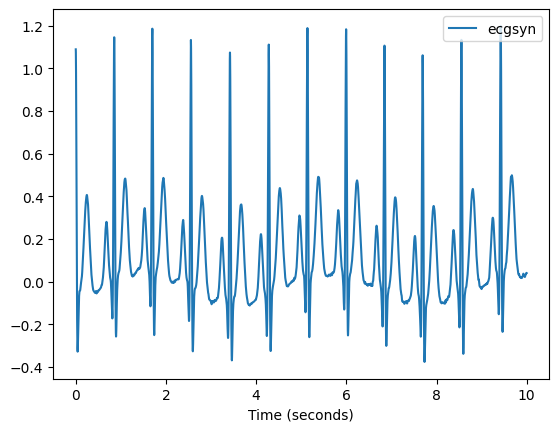

In [1]:
import neurokit2 as nk

#ecg1 = nk.ecg_simulate(duration=10, method="simple")
fs = 1000
ecg2 = nk.ecg_simulate(duration=10, sampling_rate=fs,method="ecgsyn")

# Visualize result
nk.signal_plot([ecg2], sampling_rate=fs, labels=["ecgsyn"])

In [2]:
ecg2, len(ecg2)

(array([1.08907034, 1.08473817, 1.07484011, ..., 0.03953652, 0.03966033,
        0.03995498], shape=(10000,)),
 10000)

In [3]:
ecg3  = (ecg2+1)*1000
ecg3, len(ecg3)

(array([2089.07034387, 2084.73817278, 2074.84010632, ..., 1039.53651546,
        1039.66032584, 1039.95498044], shape=(10000,)),
 10000)

[2085.33145297 2080.83199827 2070.49476688 ... 1481.04171888 1481.35784917
 1481.40131829] 2000


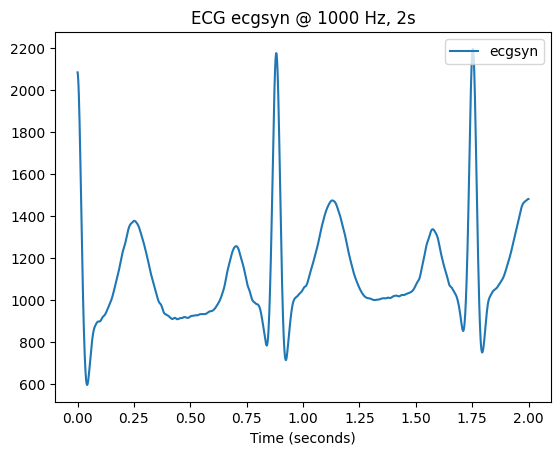

[INFO] Transmitiendo ECG en bucle. Ctrl+C para salir.

[INFO] Interrumpido por usuario.
[INFO] Puerto serial cerrado.


In [77]:
# pip install neurokit2 pyserial numpy matplotlib
import time
import sys
import serial
import numpy as np
import neurokit2 as nk
import matplotlib.pyplot as plt

# -----------------------------
# Parámetros
# -----------------------------
fs = 1000                 # Hz (frecuencia de muestreo)
duration_s = 2          # segundos por ciclo (se reenvía en bucle infinito)
PORT = "/dev/ttyACM1"    # Linux/Mac: /dev/ttyACM0 o /dev/ttyUSB0 ; Windows: "COM3"
BAUD = 115200
SHOW_PLOT = True         # Pon en False si no deseas el gráfico

# -----------------------------
# Generar señal ECG (ecgsyn) a fs
# -----------------------------
ecg2 = nk.ecg_simulate(duration=duration_s, sampling_rate=fs, method="ecgsyn")
# Asegurar formato entero si quieres envío compacto; aquí mantenemos float y lo redondeamos al vuelo
ecg2 = np.asarray(ecg2, dtype=float)
ecg2  = (ecg2+1)*1000
print(ecg2, len(ecg2))

# -----------------------------
# (Opcional) Visualizar para validar
# -----------------------------
if SHOW_PLOT:
    nk.signal_plot(ecg2, sampling_rate=fs, labels=["ecgsyn"])
    plt.title(f"ECG ecgsyn @ {fs} Hz, {duration_s}s")
    plt.show(block=False)
    plt.pause(0.1)

# -----------------------------
# Envío por Serial en tiempo real
# -----------------------------
sleep_s = 1.0 / fs

def open_serial(port, baud):
    try:
        ser = serial.Serial(port, baud, timeout=1)
        time.sleep(2.0)  # dar tiempo al reset del Arduino (USB nativo)
        ser.reset_input_buffer()
        ser.reset_output_buffer()
        return ser
    except Exception as e:
        print(f"[ERROR] No se pudo abrir {port} @ {baud} -> {e}")
        sys.exit(1)

def main():
    ser = open_serial(PORT, BAUD)

    # Leer "READY" opcional del Arduino
    t0 = time.time()
    while time.time() - t0 < 3.0:
        if ser.in_waiting:
            line = ser.readline().decode(errors="ignore").strip()
            if "READY" in line:
                print("[INFO] Arduino listo:", line)
                break

    print("[INFO] Transmitiendo ECG en bucle. Ctrl+C para salir.")
    idx = 0

    try:
        while True:
            # Recorremos ecg2 y lo reenviamos en bucle infinito
            for val in ecg2:
                # Si quieres ASCII: idx,valor\n
                # Redondeo a int para Serial Plotter más “limpio”; usa float si quieres mayor precisión.
                ival = int(round(val))

                packet = f"{idx},{ival}\n"
                ser.write(packet.encode())

                # (Opcional) leer retornos del Arduino sin bloquear
                if ser.in_waiting:
                    rx = ser.readline().decode(errors="ignore").strip()
                    # print("RX:", rx)  # descomenta si quieres ver ACK/diagnóstico

                # Temporización “tiempo real”
                time.sleep(sleep_s)
                idx += 1

            # Al terminar el vector, reinicia y continúa
            # (así simulas streaming continuo)
    except KeyboardInterrupt:
        print("\n[INFO] Interrumpido por usuario.")
    finally:
        ser.close()
        print("[INFO] Puerto serial cerrado.")

if __name__ == "__main__":
    main()


In [53]:
!ls /dev/ttyACM*

/dev/ttyACM0


In [67]:
!lsof /dev/ttyACM0

lsof: WARNING: can't stat() overlay file system /mnt/disco/docker/overlay2/a7b01f4d8179ef03f2b955f8fdeffdd3952ddda0bf019d1506705338ce77cd42/merged
      Output information may be incomplete.
lsof: WARNING: can't stat() overlay file system /mnt/disco/docker/overlay2/2e570d64e994bf370ef509f3530011a07863de648d42b528e703fef8a13acafc/merged
      Output information may be incomplete.
lsof: WARNING: can't stat() nsfs file system /run/docker/netns/06a008c76867
      Output information may be incomplete.
lsof: WARNING: can't stat() nsfs file system /run/docker/netns/d79d52656fe2
      Output information may be incomplete.
COMMAND      PID    USER   FD   TYPE DEVICE SIZE/OFF NODE NAME
serial-mo 160979 hinton2    3u   CHR  166,0      0t0 2675 /dev/ttyACM0


In [68]:
!fuser -v /dev/ttyACM0


                     USER        PID ACCESS COMMAND
/dev/ttyACM0:        hinton2   160979 F.... serial-monitor


In [70]:
ser = serial.Serial("/dev/ttyACM0", 115200, timeout=1, exclusive=True)


In [71]:
ser.close()